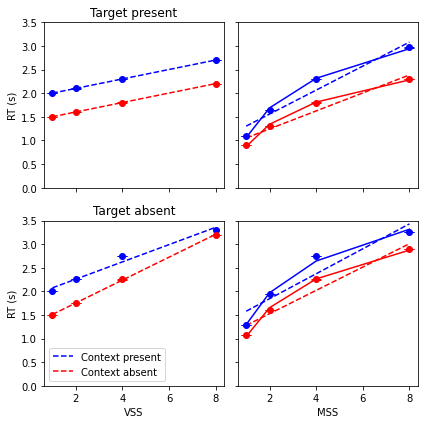

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from sklearn.model_selection import ParameterGrid
from scipy.stats import t

def simulate(condition):
    # Condition is a dictionary containing the values of the parameters to simulate
    vss = condition['VSS']
    mss = condition['MSS']
    context_present = condition['context_present']
    target_present = condition['target_present']
    if target_present:
        value = 1
    else:
        value = 2.5
    solution = pyddm.Model(drift=pyddm.DriftConstant(drift=0.25 + 1/mss), noise=pyddm.NoiseConstant(noise=0.03), bound=pyddm.BoundConstant(B=0.6+0.05*(vss-1)*value + 0.25*context_present), overlay=pyddm.OverlayNonDecision(nondectime=0.3), T_dur=3.3).solve()
    sample = solution.resample(10000)
    rts = np.concatenate((sample.choice_upper, sample.choice_lower))
    if rts.size == 0:
        rts = np.array([3.3])
    error_bars = t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts))
    return np.mean(rts), error_bars

# Values of VSS and MSS to simulate
VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])
context_present = np.array([True, False])
target_present = np.array([True, False])


fix, axs = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)
plt.ylim(0, 3.5)

# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'MSS': [4], 'context_present': context_present, 'target_present': target_present})
grid_2 = ParameterGrid({'VSS': [4], 'context_present': context_present, 'target_present': target_present})

# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}

color = {False: 'red', True: 'blue'}

# Iterate over all conditions
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['VSS'] = vss
        simulated_data = simulate(condition)
        RT_means.append(simulated_data[0])
        RT_intervals.append(simulated_data[1])
    # Extract lower and upper bounds for error bars
    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['MSS'] = mss
        simulated_data = simulate(condition)
        RT_means.append(simulated_data[0])
        RT_intervals.append(simulated_data[1])
    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])

axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
axs[1,0].legend(['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')


plt.tight_layout()
plt.show()
plt.close()




In [5]:
import os
import pandas as pd
stimuli_to_reject = ['S4_shelves_029_book_002.jpg', 'S4_sky_004_kite_004.jpg', 'S1_building_026_person_012.jpg', 'S4_shelves_037_book_010.jpg', 'S4_jungle_009_bird_009.jpg', 'S4_mountain_026_horse_001.jpg']
folder_path = os.path.join("..","Data","Preprocessed")
# Get all the files in the folder
files = os.listdir(folder_path)
# Iterate through all the files and save the data in a pandas dataframe
data = pd.DataFrame()
for file in files:
    if file.endswith('.csv') or file.endswith('.xlsx'):
        file_data = pd.read_csv(os.path.join(folder_path, file)) if file.endswith('.csv') else pd.read_excel(os.path.join(folder_path, file))
        file_data = file_data[['CONTEXT', 'TARGET', 'MEM_SET_SIZE', 'VISUAL_SET_SIZE', 'key_resp.rt', 'key_resp.corr','FILE_SEARCH_IMAGE']]
        file_data.columns = ['context_present', 'target_present', 'mss', 'vss', 'rt', 'correct_response','stimulus']
        # Remove rows where the rt is NaN
        file_data = file_data[file_data.rt.notna()]
        # Append the data from the file to the dataframe if it passes the accuracy filter
        if file_data.correct_response.mean() >= 0.55:
            #use concat instead of append
            data = pd.concat([data, file_data])

# filter correct responses
data = data[data.correct_response == 1]

#Filter stimuli
data = data[~data.stimulus.isin(stimuli_to_reject)]

In [6]:
# filtering was made by taking only the trials of subjects that had an accuracy of at least 0.55

# I need to iterate through a folder with all the subjects, their files will be in csv or xlsx format
# I am only interested in these columns: CONTEXT, TARGET, MEM_SET_SIZE, VISUAL_SET_SIZE, key_resp.rt,key_resp.corr
# These columns should be renamed to: context_present, target_present, mss, vss, rt, correct_response
# Their possible values are: context_present: 0, 1; target_present: 0, 1; mss: 1, 2, 4, 8; vss: 1, 2, 4, 8; rt: float; correct_response: 0, 1
# There are 3 steps after this:
# 1) I need to calculate the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss
# This is so that I can plot the data as I did for the simulated data
# 2) I need to fit the data to the model and extract the parameters. Then I can plot the data as I did for the simulated data
# But i can do so with the correct parameters, not the ones I used to simulate the data.
# 3) If i can find a relationship between the correct parameters and the VSS or the MSS, then it can be a very good result


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from IPython.display import clear_output

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])


fig, axs = plt.subplots(4, 2, figsize=(6,12), sharex=True, sharey=True)



# Now I proceed with step 1
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])

axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
axs[1,0].legend(['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')

# Now I proceed with step 2

# Initialize a dataframe to store the parameters of the model and the parameters of the grid
model_parameters = pd.DataFrame(columns=['drift', 'noise', 'bound', 'overlay', 'T_dur', 'mss', 'vss', 'context_present', 'target_present'])

grid_1_subplot_dict = {'target_present': {True: axs[2, 0], False: axs[3, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[2, 1], False: axs[3, 1]}}
# I use the same grids as before
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        # Now I need to fit the data to the model
        T_dur = 8
        rts = np.array([])
        if condition['target_present']:
            value = 1
        else:
            value = 2.5
        for i in range(0,10):
            fittable_model = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=0, maxval=1.25, default=0.25 + 1/condition['mss'])), noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=0.8, default=0.1)), bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=.6, maxval=3, default=0.6+0.05*(condition['vss']-1)*value + 0.25*condition['context_present'])), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5, default=.3)), T_dur=T_dur)
            sample = pyddm.Sample.from_pandas_dataframe(filtered_data, rt_column_name='rt', choice_column_name='correct_response')
            fittable_model = pyddm.fit_adjust_model(sample,fittable_model,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)        
            # Now I need to extract the parameters to the dataframe using loc
            model_parameters.loc[len(model_parameters)] = [fittable_model.parameters()['drift']['drift'], fittable_model.parameters()['noise']['noise'], fittable_model.parameters()['bound']['B'], fittable_model.parameters()['overlay']['nondectime'], T_dur, condition['mss'], condition['vss'], condition['context_present'], condition['target_present']]
            model_sample = fittable_model.solve().resample(1000)
            rts = np.concatenate((rts, np.concatenate((model_sample.choice_upper, model_sample.choice_lower))))
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        T_dur = 8
        rts = np.array([])
        if condition['target_present']:
            value = 1
        else:
            value = 2.5
        for i in range(0,10):
            filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
            fittable_model = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=0, maxval=1.25, default=0.25 + 1/condition['mss'])), noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=0.8, default=0.1)), bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=.6, maxval=3, default=0.6+0.05*(condition['vss']-1)*value + 0.25*condition['context_present'])), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5, default=.3)), T_dur=T_dur)
            sample = pyddm.Sample.from_pandas_dataframe(filtered_data, rt_column_name='rt', choice_column_name='correct_response')
            fittable_model = pyddm.fit_adjust_model(sample,fittable_model,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)   
            # Now I need to extract the parameters to the dataframe
            model_parameters.loc[len(model_parameters)] = [fittable_model.parameters()['drift']['drift'], fittable_model.parameters()['noise']['noise'], fittable_model.parameters()['bound']['B'], fittable_model.parameters()['overlay']['nondectime'], T_dur, condition['mss'], condition['vss'], condition['context_present'], condition['target_present']]
            model_sample = fittable_model.solve().resample(1000)
            rts = np.concatenate((rts, np.concatenate((model_sample.choice_upper, model_sample.choice_lower))))
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
axs[2, 0].set_ylabel('RT (s)')
axs[3, 0].set_ylabel('RT (s)')
axs[3, 0].set_xlabel('VSS')
axs[3, 1].set_xlabel('MSS')
axs[3,0].legend(['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[2, 0].set_title('Target present')
axs[3, 0].set_title('Target absent')
# Place a text on top of the first 4 plots that says "Subject Data", and on top of the last 4 plots that says "Fitted Model Data"
axs[0, 0].text(0.5, 1.15, 'Subject Data', horizontalalignment='center', fontsize=14, transform=axs[0, 0].transAxes)
axs[2, 0].text(0.5, 1.15, 'Fitted Model Data', horizontalalignment='center', fontsize=14, transform=axs[2, 0].transAxes)
clear_output()

plt.tight_layout()
plt.show()
plt.close()

Info: Params [1.02477095 0.7692384  2.03382562 0.00300317] gave 422.28914967243804
Info: Params [0.71727975 0.53842191 1.42355903 0.00224836] gave 422.28914967243793
Info: Params [0.9392227  0.71021648 1.84995278 0.01898459] gave 422.6343166178059
Info: Params [0.95274712 0.71866517 1.88135508 0.01460239] gave 422.5124561618816
Info: Params [0.91135093 0.68410032 1.80872502 0.00405317] gave 422.28914967243793
Info: Params [1.04106031 0.78146593 2.06615457 0.00296542] gave 422.28914967243827
Info: Params [0.90355967 0.67989694 1.78874371 0.00873563] gave 422.39750550704775
Info: Params [0.95587073 0.71751886 1.89708187 0.00416891] gave 422.28914967243793
Info: Params [0.73706606 0.55327439 1.4628282  0.00264454] gave 422.28914967243793
Info: Params [6.97674531e-01 5.23705390e-01 1.38464926e+00 8.22865410e-04] gave 422.2891496724387
Info: Params [0.9232112  0.67072964 1.70888314 0.169397  ] gave 292.2316489882247
Info: Params [0.88587836 0.63123784 1.67964416 0.12071387] gave 292.2976202

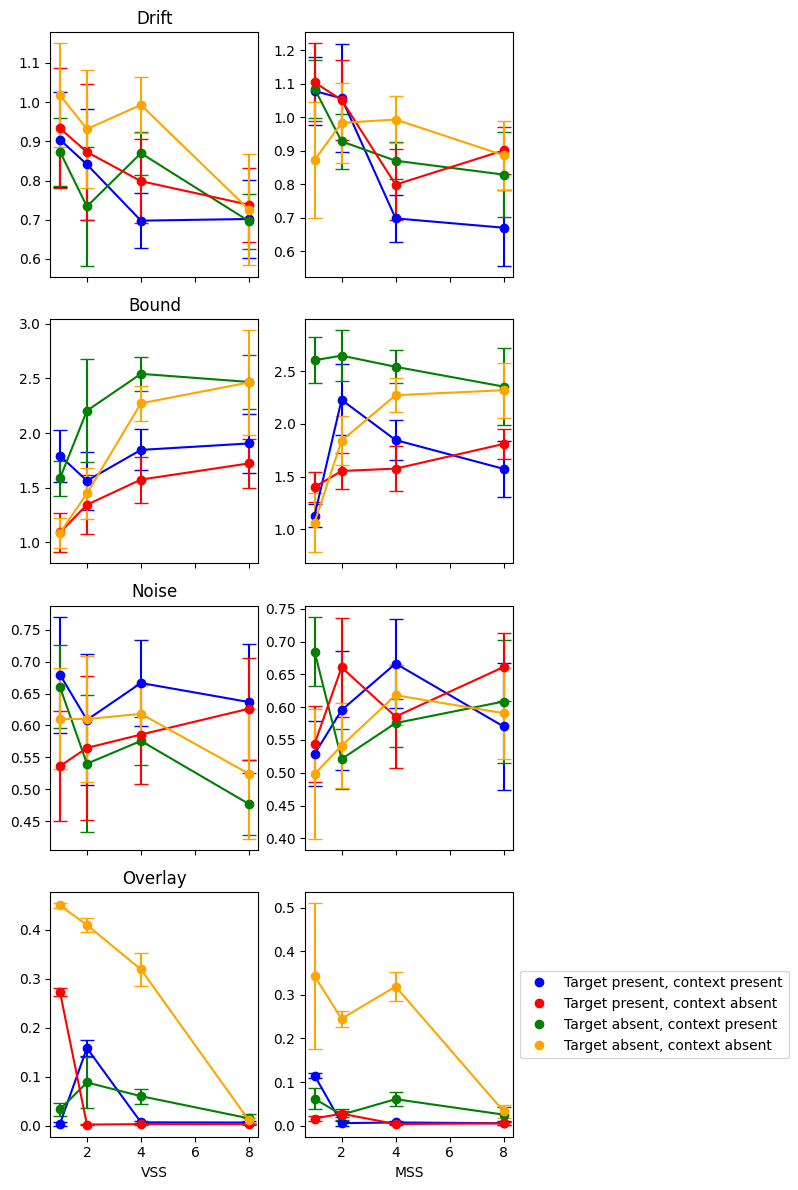

In [ ]:
# Now I proceed with step 3
# I need to plot each of the fitted parameters against the VSS and the MSS
# I can use the same grids as before
fig, axs = plt.subplots(4, 2, figsize=(8,12), sharex=True)
# For each parameter I need to plot the data for context present and context absent
# I need a grid with a color for each combination of target present and context present
color = {'target_present':{'context_present': 'blue', 'context_absent': 'red'}, 'target_absent':{'context_present': 'green', 'context_absent': 'orange'}}
# I need a grid to map each parameter to a subplot
axis_grid_1 = {'drift':axs[0, 0], 'bound':axs[1, 0], 'noise':axs[2, 0], 'overlay':axs[3, 0]}
axis_grid_2 = {'drift':axs[0, 1], 'bound':axs[1, 1], 'noise':axs[2, 1], 'overlay':axs[3, 1]}
# I need to set the title of each subplot to the parameter name
axs[0, 0].set_title('Drift')
axs[1, 0].set_title('Bound')
axs[2, 0].set_title('Noise')
axs[3, 0].set_title('Overlay')

handles = []
labels = ['Target present, context present', 'Target present, context absent', 'Target absent, context present', 'Target absent, context absent']
# I need to iterate through the parameters
for parameter in ['drift', 'bound', 'noise', 'overlay']:
    # I need to iterate through the grids
    for grid in [grid_1, grid_2]:
        # I need to iterate through the conditions
        for condition in grid:
            # I need to filter the dataframe to get only the rows that match the condition
            # Now I need to plot the data
            target_present_string = 'target_present' if condition['target_present'] else 'target_absent'
            context_present_string = 'context_present' if condition['context_present'] else 'context_absent'
            parameter_values = []
            parameters_standard_error = []
            if grid == grid_1:
                
                for vss in VSS:
                    condition['vss'] = vss
                    filtered_data = model_parameters[(model_parameters.context_present == condition['context_present']) & (model_parameters.target_present == condition['target_present']) & (model_parameters.mss == condition['mss']) & (model_parameters.vss == condition['vss'])]
                    parameter_values.append(filtered_data[parameter].mean())
                    parameters_standard_error.append(t.ppf(0.975, filtered_data[parameter].size-1)*filtered_data[parameter].std()/np.sqrt(filtered_data[parameter].size))
                axis_grid_1[parameter].errorbar(VSS, parameter_values, yerr=parameters_standard_error, fmt='o-', capsize=5, label='Mean and 95% CI',color=color[target_present_string][context_present_string])

            else:
                for mss in MSS:
                    condition['mss'] = mss
                    filtered_data = model_parameters[(model_parameters.context_present == condition['context_present']) & (model_parameters.target_present == condition['target_present']) & (model_parameters.mss == condition['mss']) & (model_parameters.vss == condition['vss'])]
                    parameter_values.append(filtered_data[parameter].mean())
                    parameters_standard_error.append(t.ppf(0.975, filtered_data[parameter].size-1)*filtered_data[parameter].std()/np.sqrt(filtered_data[parameter].size))
                axis_grid_2[parameter].errorbar(MSS, parameter_values, yerr=parameters_standard_error, fmt='o-', capsize=5, label='Mean and 95% CI',color=color[target_present_string][context_present_string])


# Get the handles and labels according to the "color" dictionary and the "labels" list
for key in color:
    for key2 in color[key]:
        handles.append(plt.Line2D([0,0],[0,0],color=color[key][key2], marker='o', linestyle=''))
# Add the X label to the last row of subplots
axs[3, 0].set_xlabel('VSS')
axs[3, 1].set_xlabel('MSS')
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()


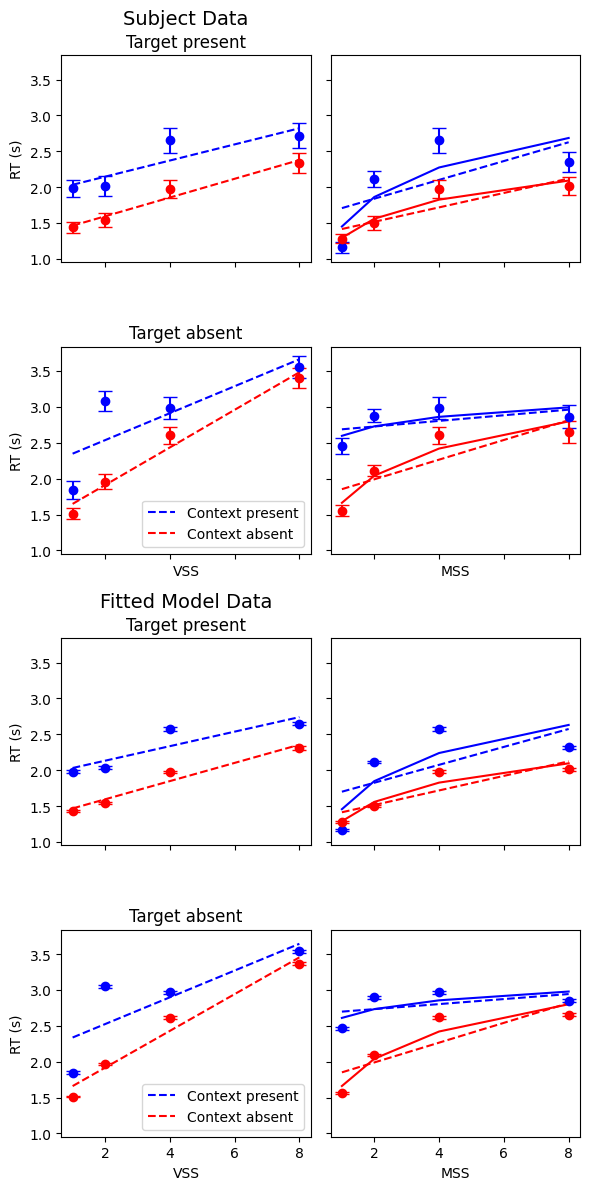

In [ ]:
# Fix the noise

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from IPython.display import clear_output

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])


fig, axs = plt.subplots(4, 2, figsize=(6,12), sharex=True, sharey=True)



# Now I proceed with step 1
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])

axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
axs[1,0].legend(['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')

# Now I proceed with step 2

# Initialize a dataframe to store the parameters of the model and the parameters of the grid
model_parameters = pd.DataFrame(columns=['drift', 'noise', 'bound', 'overlay', 'T_dur', 'mss', 'vss', 'context_present', 'target_present'])

grid_1_subplot_dict = {'target_present': {True: axs[2, 0], False: axs[3, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[2, 1], False: axs[3, 1]}}
# I use the same grids as before
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        # Now I need to fit the data to the model
        T_dur = 8
        rts = np.array([])
        if condition['target_present']:
            value = 1
        else:
            value = 2.5
        for i in range(0,10):
            fittable_model = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=0.0, maxval=1.25, default=0.25 + 1/condition['mss'])), noise=pyddm.NoiseConstant(noise=0.5), bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=.6, maxval=3, default=0.6+0.05*(condition['vss']-1)*value + 0.25*condition['context_present'])), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.9, default=.3)), T_dur=T_dur)
            sample = pyddm.Sample.from_pandas_dataframe(filtered_data, rt_column_name='rt', choice_column_name='correct_response')
            fittable_model = pyddm.fit_adjust_model(sample,fittable_model,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)        
            # Now I need to extract the parameters to the dataframe using loc
            model_parameters.loc[len(model_parameters)] = [fittable_model.parameters()['drift']['drift'], fittable_model.parameters()['noise']['noise'], fittable_model.parameters()['bound']['B'], fittable_model.parameters()['overlay']['nondectime'], T_dur, condition['mss'], condition['vss'], condition['context_present'], condition['target_present']]
            model_sample = fittable_model.solve().resample(1000)
            rts = np.concatenate((rts, np.concatenate((model_sample.choice_upper, model_sample.choice_lower))))
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        T_dur = 8
        rts = np.array([])
        if condition['target_present']:
            value = 1
        else:
            value = 2.5
        for i in range(0,10):
            filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
            fittable_model = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=0.0, maxval=1.25, default=0.25 + 1/condition['mss'])), noise=pyddm.NoiseConstant(noise=0.5), bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=.6, maxval=3, default=0.6+0.05*(condition['vss']-1)*value + 0.25*condition['context_present'])), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.9, default=.3)), T_dur=T_dur)
            sample = pyddm.Sample.from_pandas_dataframe(filtered_data, rt_column_name='rt', choice_column_name='correct_response')
            fittable_model = pyddm.fit_adjust_model(sample,fittable_model,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)   
            # Now I need to extract the parameters to the dataframe
            model_parameters.loc[len(model_parameters)] = [fittable_model.parameters()['drift']['drift'], fittable_model.parameters()['noise']['noise'], fittable_model.parameters()['bound']['B'], fittable_model.parameters()['overlay']['nondectime'], T_dur, condition['mss'], condition['vss'], condition['context_present'], condition['target_present']]
            model_sample = fittable_model.solve().resample(1000)
            rts = np.concatenate((rts, np.concatenate((model_sample.choice_upper, model_sample.choice_lower))))
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
axs[2, 0].set_ylabel('RT (s)')
axs[3, 0].set_ylabel('RT (s)')
axs[3, 0].set_xlabel('VSS')
axs[3, 1].set_xlabel('MSS')
axs[3,0].legend(['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[2, 0].set_title('Target present')
axs[3, 0].set_title('Target absent')
# Place a text on top of the first 4 plots that says "Subject Data", and on top of the last 4 plots that says "Fitted Model Data"
axs[0, 0].text(0.5, 1.15, 'Subject Data', horizontalalignment='center', fontsize=14, transform=axs[0, 0].transAxes)
axs[2, 0].text(0.5, 1.15, 'Fitted Model Data', horizontalalignment='center', fontsize=14, transform=axs[2, 0].transAxes)
clear_output()

plt.tight_layout()
plt.show()
plt.close()

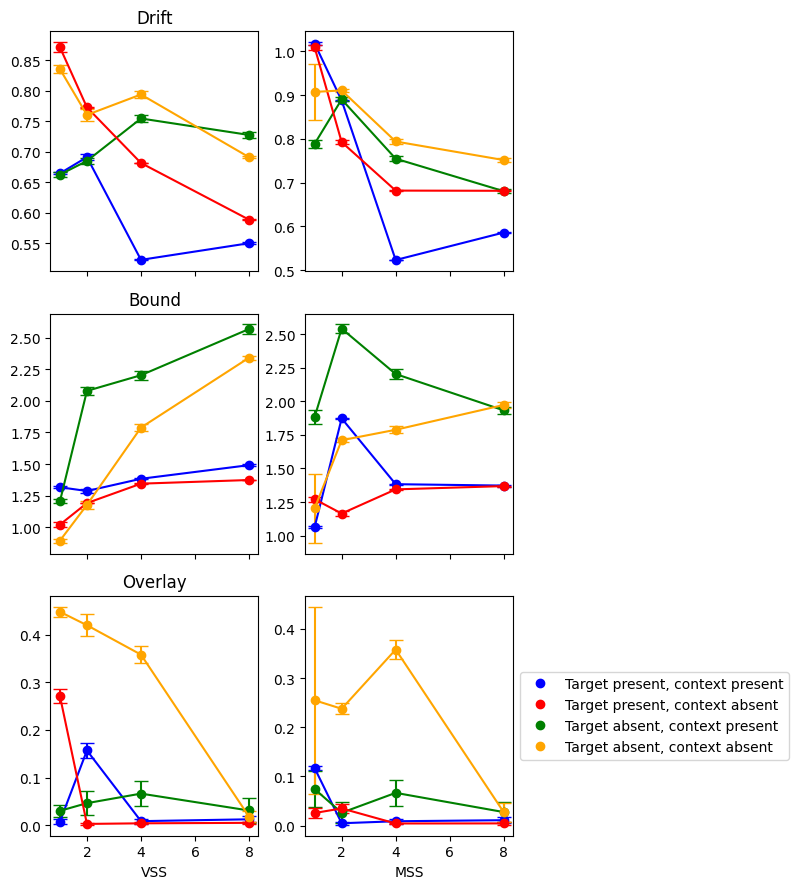

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8,9), sharex=True)
# For each parameter I need to plot the data for context present and context absent
# I need a grid with a color for each combination of target present and context present
color = {'target_present':{'context_present': 'blue', 'context_absent': 'red'}, 'target_absent':{'context_present': 'green', 'context_absent': 'orange'}}
# I need a grid to map each parameter to a subplot
axis_grid_1 = {'drift':axs[0, 0], 'bound':axs[1, 0], 'overlay':axs[2, 0]}
axis_grid_2 = {'drift':axs[0, 1], 'bound':axs[1, 1], 'overlay':axs[2, 1]}
# I need to set the title of each subplot to the parameter name
axs[0, 0].set_title('Drift')
axs[1, 0].set_title('Bound')
axs[2, 0].set_title('Overlay')

handles = []
labels = ['Target present, context present', 'Target present, context absent', 'Target absent, context present', 'Target absent, context absent']
# I need to iterate through the parameters
for parameter in ['drift', 'bound', 'overlay']:
    # I need to iterate through the grids
    for grid in [grid_1, grid_2]:
        # I need to iterate through the conditions
        for condition in grid:
            # I need to filter the dataframe to get only the rows that match the condition
            # Now I need to plot the data
            target_present_string = 'target_present' if condition['target_present'] else 'target_absent'
            context_present_string = 'context_present' if condition['context_present'] else 'context_absent'
            parameter_values = []
            parameters_standard_error = []
            if grid == grid_1:
                
                for vss in VSS:
                    condition['vss'] = vss
                    filtered_data = model_parameters[(model_parameters.context_present == condition['context_present']) & (model_parameters.target_present == condition['target_present']) & (model_parameters.mss == condition['mss']) & (model_parameters.vss == condition['vss'])]
                    parameter_values.append(filtered_data[parameter].mean())
                    parameters_standard_error.append(t.ppf(0.975, filtered_data[parameter].size-1)*filtered_data[parameter].std()/np.sqrt(filtered_data[parameter].size))
                axis_grid_1[parameter].errorbar(VSS, parameter_values, yerr=parameters_standard_error, fmt='o-', capsize=5, label='Mean and 95% CI',color=color[target_present_string][context_present_string])

            else:
                for mss in MSS:
                    condition['mss'] = mss
                    filtered_data = model_parameters[(model_parameters.context_present == condition['context_present']) & (model_parameters.target_present == condition['target_present']) & (model_parameters.mss == condition['mss']) & (model_parameters.vss == condition['vss'])]
                    parameter_values.append(filtered_data[parameter].mean())
                    parameters_standard_error.append(t.ppf(0.975, filtered_data[parameter].size-1)*filtered_data[parameter].std()/np.sqrt(filtered_data[parameter].size))
                axis_grid_2[parameter].errorbar(MSS, parameter_values, yerr=parameters_standard_error, fmt='o-', capsize=5, label='Mean and 95% CI',color=color[target_present_string][context_present_string])



# Get the handles and labels according to the "color" dictionary and the "labels" list
for key in color:
    for key2 in color[key]:
        handles.append(plt.Line2D([0,0],[0,0],color=color[key][key2], marker='o', linestyle=''))
# Add the X label to the last row of subplots
axs[2, 0].set_xlabel('VSS')
axs[2, 1].set_xlabel('MSS')
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
from pyddm.plot import model_gui,plot_decision_variable_distribution

m = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=1, maxval=20)), bound= pyddm.BoundConstant(B=pyddm.Fittable(minval=0, maxval=15)),noise=pyddm.NoiseConstant(noise=0.5), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=1)), T_dur=8)
filtered_data = data[(data.context_present == True) & (data.target_present == False) & (data.mss == 4) & (data.vss == 4)]
sample = pyddm.Sample.from_pandas_dataframe(filtered_data, rt_column_name='rt', choice_column_name='correct_response')
m = pyddm.fit_adjust_model(sample,m,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)
model_sample = m.solve().resample(1000)
model_sample_corrects = model_sample.choice_upper
model_sample_errors = model_sample.choice_lower

# I want to plot filtered_data as a probability distribution, so i need to plot the histogram of the rt and then fit a probability distribution to it

import seaborn as sns


# Combine model_sample_corrects and model_sample_errors into a single array
combined_model_data = np.concatenate([model_sample_corrects, model_sample_errors])

# Create a DataFrame for combined model data
model_df = pd.DataFrame({
    'correct_response': np.concatenate([np.ones_like(model_sample_corrects), np.zeros_like(model_sample_errors)]),
    'rt': combined_model_data
})


# Create a violin plot for observed data
plt.figure(figsize=(10, 6))
sns.violinplot(x="correct_response", y="rt", data=filtered_data, hue="correct_response", split=True, inner="quart",
               palette="muted", density_norm="count", common_norm=True,alpha=0.5)

# Create a violin plot for combined model data
sns.violinplot(x="correct_response", y="rt", data=model_df, hue="correct_response", split=True, inner="quart",
               palette={0.0:"red",1.0:"green"}, density_norm="count", common_norm=True,alpha=0.5)

# Set plot labels and title
plt.xlabel("Response Type")
plt.ylabel("Response Time")
plt.title("Probability Distribution of Response Times (Observed vs. Model)")

# Create lines for the legend with the same colors as the violin plots
from matplotlib.lines import Line2D
red_line = Line2D([0], [0], color='red', lw=4)
green_line = Line2D([0], [0], color='green', lw=4)
blue_line = Line2D([0], [0], color='blue', lw=4)
orange_line = Line2D([0], [0], color='orange', lw=4)
handles = [blue_line, orange_line, red_line, green_line]

# Show legend
plt.legend(handles=handles,labels=["Observed Errors", "Observed Corrects", "Model Errors", "Model Corrects"])

# Show the plot
plt.show()
plt.close()

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
#Fit ddm to all the data
import numpy as np
import pyddm
from pyddm.plot import model_gui
#Custom drift for pyddm
class DriftCustom(pyddm.models.Drift):
    name = "Custom Drift depending on MSS and context"
    required_parameters = ["driftmss", "context_present","bias"]
    required_conditions = ["mss", "context_present"]
    
    def get_drift(self, conditions, **kwargs):
        return self.driftmss/conditions['mss'] + self.context_present*conditions['context_present'] + self.bias
class BoundCustom(pyddm.models.Bound):
    name = "Custom bound depending on VSS and target"
    required_parameters = ["boundvss", "target_present","bias"]
    required_conditions = ["vss", "target_present"]

    def get_bound(self, conditions, **kwargs):
        return self.boundvss*conditions['vss'] + self.target_present*(1-conditions['target_present']) + self.bias
class OverlayCustom(pyddm.models.Overlay):
    name = "Custom overlay depending on context"
    required_parameters = ["nondectime","bias"]
    required_conditions = ["target_present"]

    def apply(self, solution):
        choice_upper = solution.choice_upper
        choice_lower = solution.choice_lower
        m = solution.model
        cond = solution.conditions
        undec = solution.undec
        evolution = solution.evolution
        shifts = int(((1-cond["target_present"])*self.nondectime + self.bias)/m.dt) # truncate
        newchoice_upper = np.zeros(choice_upper.shape, dtype=choice_upper.dtype)
        newchoice_lower = np.zeros(choice_lower.shape, dtype=choice_lower.dtype)
        if shifts > 0:
            newchoice_upper[shifts:] = choice_upper[:-shifts]
            newchoice_lower[shifts:] = choice_lower[:-shifts]
        elif shifts < 0:
            newchoice_upper[:shifts] = choice_upper[-shifts:]
            newchoice_lower[:shifts] = choice_lower[-shifts:]
        else:
            newchoice_upper = choice_upper
            newchoice_lower = choice_lower
        return pyddm.Solution(newchoice_upper, newchoice_lower, m, cond, undec, evolution)

m = pyddm.Model(drift=DriftCustom(driftmss=pyddm.Fittable(minval=0, maxval=5),bias=pyddm.Fittable(minval=0, maxval=5),context_present=pyddm.Fittable(minval=-5, maxval=0)), bound = BoundCustom(boundvss=pyddm.Fittable(minval=0, maxval=5),bias=pyddm.Fittable(minval=0, maxval=5),target_present=pyddm.Fittable(minval=0.5, maxval=1,default=0.75)),noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=0.1,maxval=1)), overlay=OverlayCustom(nondectime=pyddm.Fittable(minval=0.1,maxval=0.6),bias=pyddm.Fittable(minval=0.1,maxval=0.6)), T_dur=8,dt=0.001)
sample = pyddm.Sample.from_pandas_dataframe(data, rt_column_name='rt', choice_column_name='correct_response')
m = pyddm.fit_adjust_model(sample,m,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)



Info: Params [ 0.84723916 -0.34501221  1.20955125  0.99762441  0.196914    0.58931053
  1.6324273   0.13726001  0.10599978] gave 10338.636990193389


In [ ]:
print(m.parameters())

{'drift': {'driftmss': Fitted(0.8823350528133623, minval=0, maxval=5), 'context_present': Fitted(-0.35578956726917194, minval=-5, maxval=0), 'bias': Fitted(1.2602996447895096, minval=0, maxval=5)}, 'noise': {'noise': Fitted(1.0, minval=0.1, maxval=1)}, 'bound': {'boundvss': Fitted(0.20358985214975428, minval=0, maxval=5), 'target_present': Fitted(1.0, minval=1, maxval=2), 'bias': Fitted(1.530922856767336, minval=0, maxval=5)}, 'IC': {}, 'overlay': {'nondectime': Fitted(0.10010114417471291, minval=0.1, maxval=0.6), 'bias': Fitted(0.11049168165537307, minval=0.1, maxval=0.6)}}


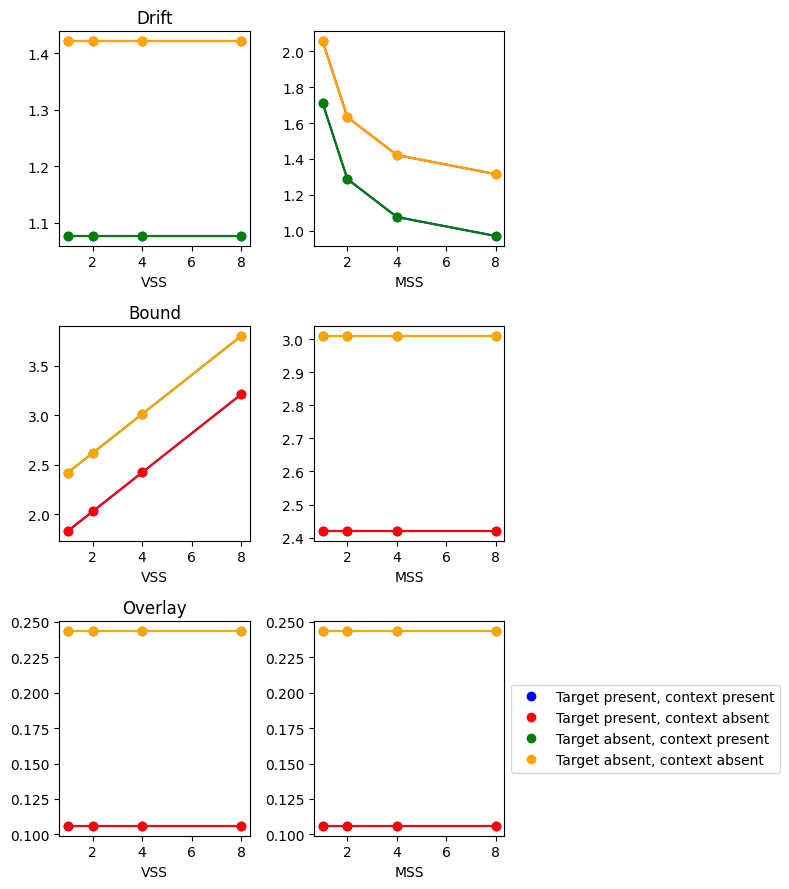

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
# Plot the parameter values for each condition

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])

grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})

fig, axs = plt.subplots(3, 2, figsize=(8,9))
# For each parameter I need to plot the data for context present and context absent
# I need a grid with a color for each combination of target present and context present
color = {'target_present':{'context_present': 'blue', 'context_absent': 'red'}, 'target_absent':{'context_present': 'green', 'context_absent': 'orange'}}
# I need a grid to map each parameter to a subplot
axis_grid_1 = {'drift':axs[0, 0], 'bound':axs[1, 0], 'overlay':axs[2, 0]}
axis_grid_2 = {'drift':axs[0, 1], 'bound':axs[1, 1], 'overlay':axs[2, 1]}
# I need to set the title of each subplot to the parameter name
axs[0, 0].set_title('Drift')
axs[1, 0].set_title('Bound')
axs[2, 0].set_title('Overlay')

parameter_functions = {'drift': lambda x: x["driftmss"]/condition['mss']+ x["context_present"]*condition['context_present'] + x["bias"], 
                       'bound': lambda x: x["boundvss"]*condition['vss'] + x['target_present']*(1-condition['target_present']) + x["bias"], 
                       'overlay': lambda x: x["nondectime"]*(1-condition['target_present']) + x["bias"]}

handles = []
labels = ['Target present, context present', 'Target present, context absent', 'Target absent, context present', 'Target absent, context absent']
# I need to iterate through the parameters
for parameter in ['drift', 'bound', 'overlay']:
    # I need to iterate through the grids
    for grid in [grid_1, grid_2]:
        # I need to iterate through the conditions
        for condition in grid:
            # I need to filter the dataframe to get only the rows that match the condition
            # Now I need to plot the data
            target_present_string = 'target_present' if condition['target_present'] else 'target_absent'
            context_present_string = 'context_present' if condition['context_present'] else 'context_absent'
            parameter_values = []
            parameters_standard_error = []
            if grid == grid_1:
                
                for vss in VSS:
                    condition['vss'] = vss
                    parameter_value = parameter_functions[parameter](m.parameters()[parameter])
                    parameter_values.append(parameter_value)
                axis_grid_1[parameter].plot(VSS, parameter_values,marker='o',color=color[target_present_string][context_present_string])

            else:
                for mss in MSS:
                    condition['mss'] = mss
                    parameter_value = parameter_functions[parameter](m.parameters()[parameter])
                    parameter_values.append(parameter_value)
                axis_grid_2[parameter].plot(MSS, parameter_values,marker='o',color=color[target_present_string][context_present_string])



# Get the handles and labels according to the "color" dictionary and the "labels" list
for key in color:
    for key2 in color[key]:
        handles.append(plt.Line2D([0,0],[0,0],color=color[key][key2], marker='o', linestyle=''))
# Add the X label to the last row of subplots
for i in range(len(axs)):
    axs[i, 0].set_xlabel('VSS')
    axs[i, 1].set_xlabel('MSS')
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()

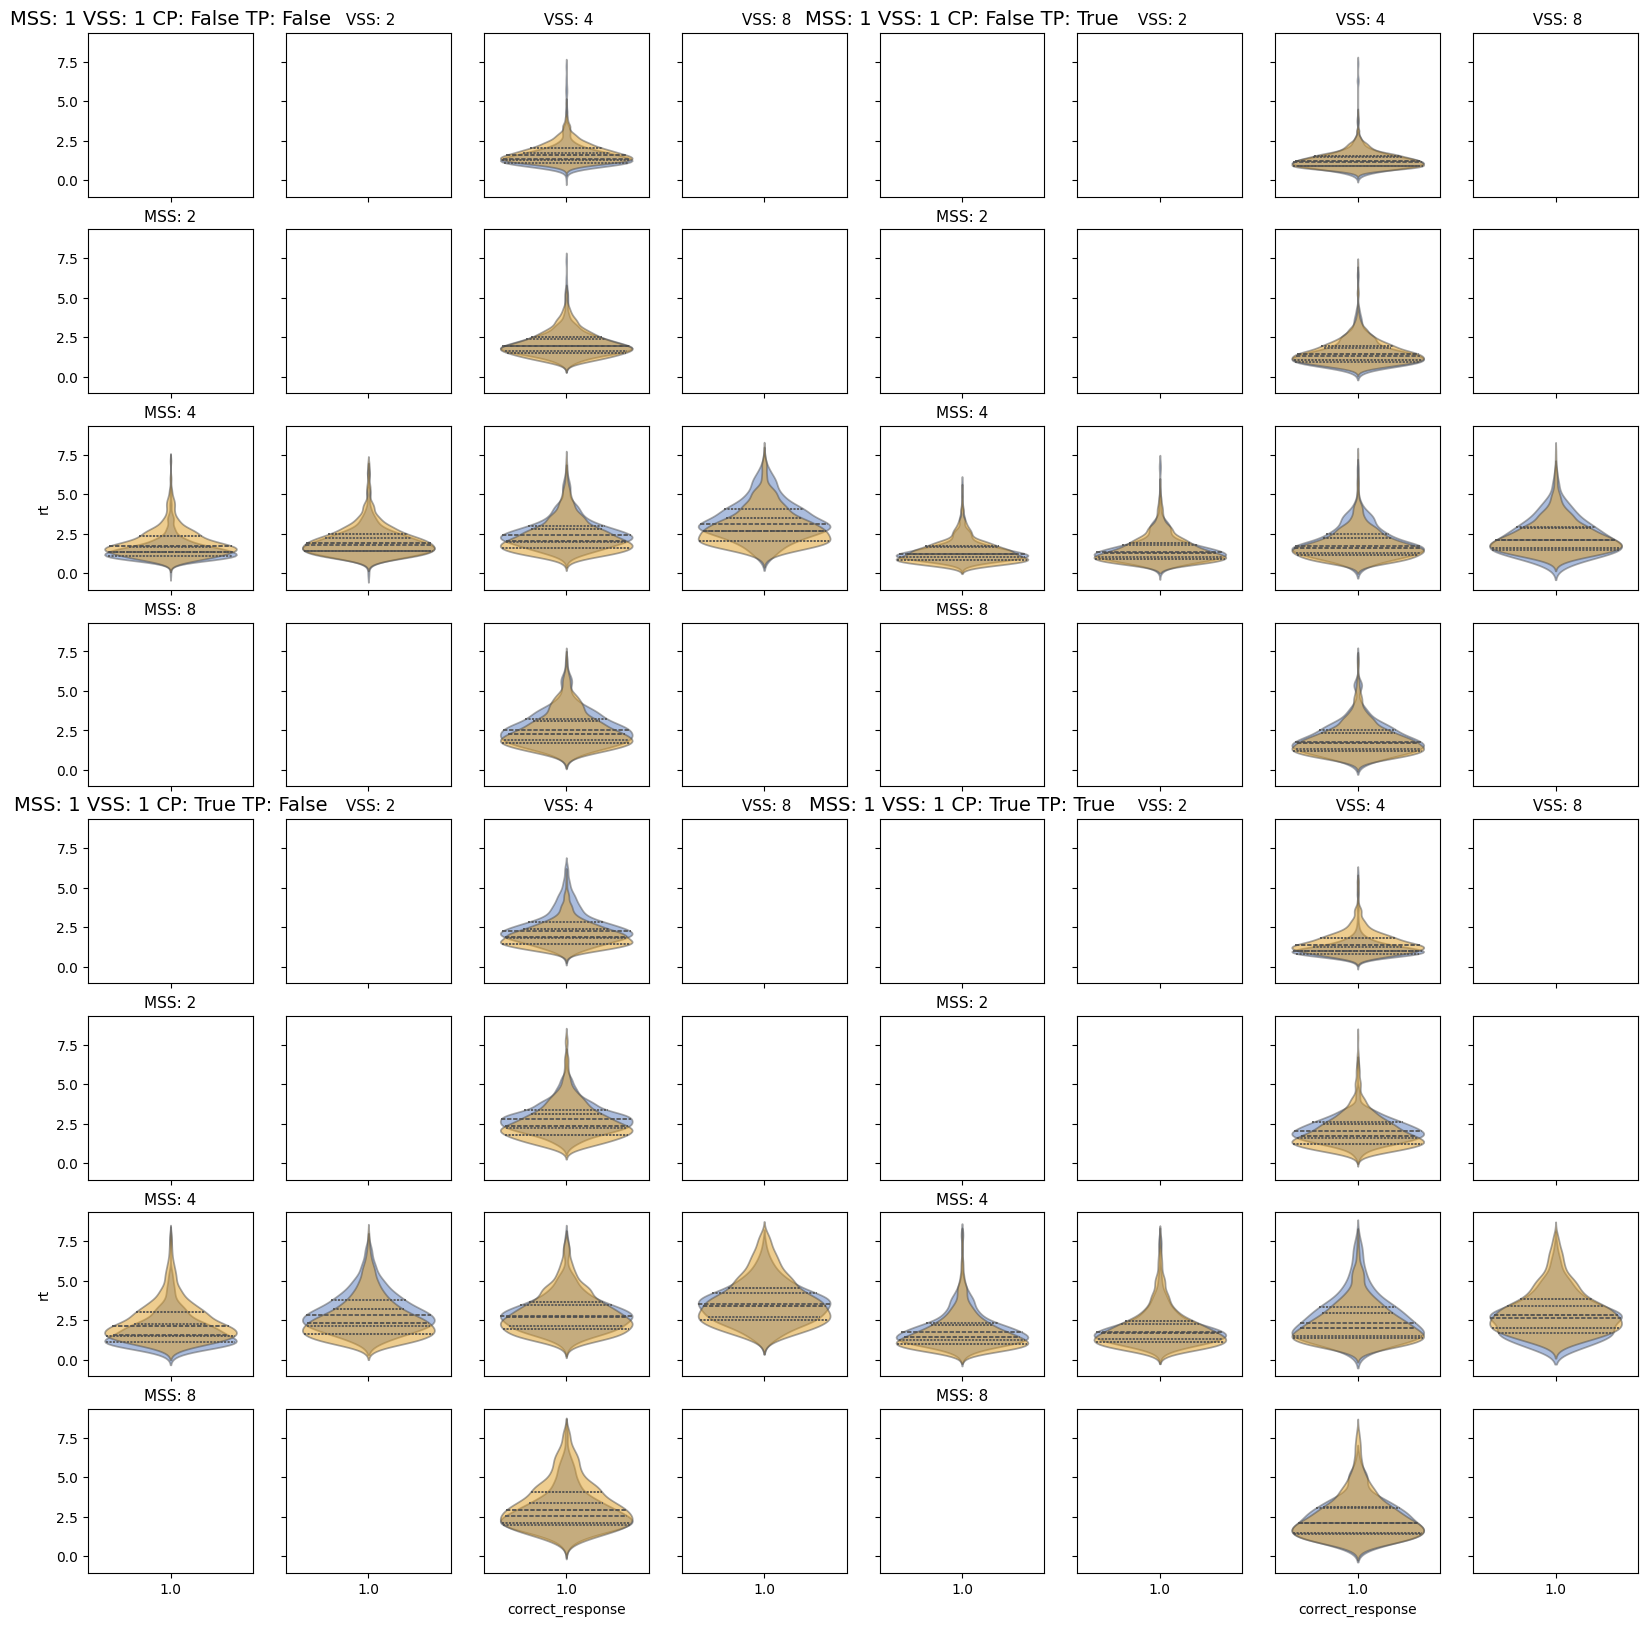

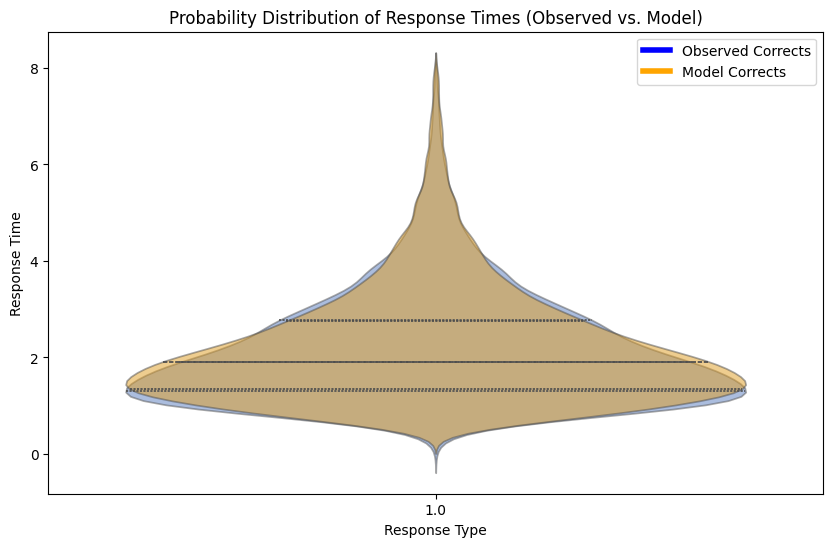

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#Grid to iterate over all possible combinations of parameters
grid = ParameterGrid({'mss': [1, 2, 4, 8], 'vss': [1, 2, 4, 8], 'context_present': [True, False], 'target_present': [True, False]})

#I need a grid of plots to plot the data for each combination of parameters, there would be 64 plots
fig, axs = plt.subplots(8, 8, figsize=(20,20), sharex=True, sharey=True)

# I need to map each combination of parameters to a subplot

model_sample_corrects = np.array([])
model_sample_errors = np.array([])
combined_model_data = np.array([])
for condition in grid:
    filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
    title = ""
    ax_index_x = int(np.log2(condition['mss'])) + 4*condition['context_present']
    ax_index_y = int(np.log2(condition['vss'])) + 4*condition['target_present']
    fontsize = 11
    if np.mod(ax_index_y,4) ==0:
        title += "MSS: " + str(condition['mss'])
    if np.mod(ax_index_x,4) ==0:
        title += " VSS: " + str(condition['vss'])
    if np.mod(ax_index_x,4) ==0 and np.mod(ax_index_y,4) ==0:
        title += " CP: " + str(condition['context_present'])
        fontsize = 14
    if np.mod(ax_index_x,4) ==0 and np.mod(ax_index_y,4) ==0:
        title += " TP: " + str(condition['target_present'])
        fontsize = 14
    
    axs[ax_index_x, ax_index_y].set_title(title, fontsize=fontsize)
    
    
    if len(filtered_data) == 0:
        continue
    sample = m.solve(conditions=condition).resample(1000)
    model_sample_corrects = np.concatenate([model_sample_corrects, sample.choice_upper])
    model_sample_errors = np.concatenate([model_sample_errors, sample.choice_lower])
    combined_model_data = np.concatenate([combined_model_data, np.concatenate([sample.choice_upper, sample.choice_lower])])
    #Do a violin plot for the model data and for the observed data in the corresponding subplot according to the condition

    # Create a DataFrame for combined model data
    model_df = pd.DataFrame({
        'correct_response': np.ones_like(sample.choice_upper),
        'rt': sample.choice_upper
    })

    
    violin = sns.violinplot(x="correct_response", y="rt", data=filtered_data,  inner="quart", hue = "correct_response",
               palette="muted", density_norm="count", common_norm=True,alpha=0.3,ax=axs[ax_index_x, ax_index_y],legend=False)
    plt.setp(violin.collections, alpha=.5)
    violin = sns.violinplot(x="correct_response", y="rt", data=model_df,  inner="quart", hue = "correct_response",
                palette={1.0:"orange"}, density_norm="count", common_norm=True,alpha=0.3,ax=axs[ax_index_x, ax_index_y],legend=False)
    plt.setp(violin.collections, alpha=.5)
plt.show()

# Create a DataFrame for combined model data
model_df = pd.DataFrame({
    'correct_response': np.ones_like(model_sample_corrects),
    'rt': model_sample_corrects
})



# Create a violin plot for observed data
plt.figure(figsize=(10, 6))

violin = sns.violinplot(x="correct_response", y="rt", data=data,  inner="quart", hue = "correct_response",
               palette="muted", density_norm="count", common_norm=True)
plt.setp(violin.collections, alpha=.5)
# Create a violin plot for combined model data
violin = sns.violinplot(x="correct_response", y="rt", data=model_df,  inner="quart", hue = "correct_response",
               palette={1.0:"orange"}, density_norm="count", common_norm=True)
plt.setp(violin.collections, alpha=.5)
# Set plot labels and title
plt.xlabel("Response Type")
plt.ylabel("Response Time")
plt.title("Probability Distribution of Response Times (Observed vs. Model)")

# Create lines for the legend with the same colors as the violin plots
from matplotlib.lines import Line2D

orange_line = Line2D([0], [0], color='orange', lw=4)
blue_line = Line2D([0], [0], color='blue', lw=4)

handles = [blue_line, orange_line]

# Show legend
plt.legend(handles=handles,labels=["Observed Corrects","Model Corrects"])

# Show the plot
plt.show()
plt.close()

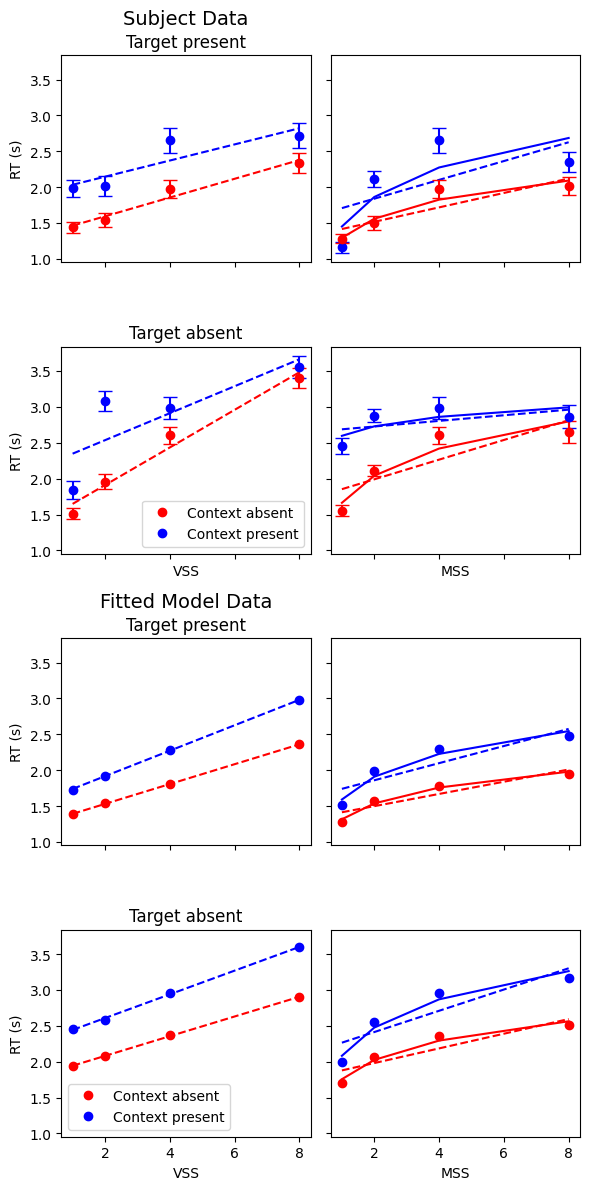

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from IPython.display import clear_output

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])


fig, axs = plt.subplots(4, 2, figsize=(6,12), sharex=True, sharey=True)



# Now I proceed with step 1
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        filtered_data = data[(data.context_present == condition['context_present']) & (data.target_present == condition['target_present']) & (data.mss == condition['mss']) & (data.vss == condition['vss'])]
        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))

    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])

axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
colors = ["red","blue"]
handles = [plt.Line2D([],[],color=colors[i], marker='o', linestyle='None') for i in range(len(colors))]
axs[1,0].legend(handles=handles,labels=['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')

# Now I proceed with step 2

# Initialize a dataframe to store the parameters of the model and the parameters of the grid
model_parameters = pd.DataFrame(columns=['drift', 'noise', 'bound', 'overlay', 'T_dur', 'mss', 'vss', 'context_present', 'target_present'])

grid_1_subplot_dict = {'target_present': {True: axs[2, 0], False: axs[3, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[2, 1], False: axs[3, 1]}}
# I use the same grids as before
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # Now I need to fit the data to the model
        model_sample = m.solve(conditions=condition).resample(10000)
        rts = model_sample.choice_upper
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_1_subplot_dict['target_present'][condition['target_present']].scatter(MSS, RT_means,label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        model_sample = m.solve(conditions=condition).resample(10000)
        rts = model_sample.choice_upper
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    grid_2_subplot_dict['target_present'][condition['target_present']].scatter(MSS, RT_means,label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
axs[2, 0].set_ylabel('RT (s)')
axs[3, 0].set_ylabel('RT (s)')
axs[3, 0].set_xlabel('VSS')
axs[3, 1].set_xlabel('MSS')
axs[3,0].legend(handles=handles,labels=['Context present', 'Context absent'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[2, 0].set_title('Target present')
axs[3, 0].set_title('Target absent')
# Place a text on top of the first 4 plots that says "Subject Data", and on top of the last 4 plots that says "Fitted Model Data"
axs[0, 0].text(0.5, 1.15, 'Subject Data', horizontalalignment='center', fontsize=14, transform=axs[0, 0].transAxes)
axs[2, 0].text(0.5, 1.15, 'Fitted Model Data', horizontalalignment='center', fontsize=14, transform=axs[2, 0].transAxes)
clear_output()

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
sample = pyddm.Sample.from_pandas_dataframe(data, rt_column_name='rt', choice_column_name='correct_response')
model_gui(m,sample)

Model(name='', drift=DriftCustom(driftmss=Fitted(0.88, minval=0, maxval=5), context_present=Fitted(-0.36, minval=-5, maxval=0), bias=Fitted(1.26, minval=0, maxval=5)), noise=NoiseConstant(noise=Fitted(1.0, minval=0.1, maxval=1)), bound=BoundCustom(boundvss=Fitted(0.2, minval=0, maxval=5), target_present=Fitted(1.0, minval=1, maxval=2), bias=Fitted(1.81, minval=0, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayCustom(nondectime=Fitted(0.1, minval=0.1, maxval=0.6), bias=Fitted(0.11049168165537307, minval=0.1, maxval=0.6)), dx=0.005, dt=0.001, T_dur=8, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='Negative log likelihood', value=10423.111192159784, nparams=9, samplesize=8067, mess=''))

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})



MSS = np.array([1, 2, 4, 8])
results_df = pd.DataFrame(columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])
for condition in grid:
 
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []


    for subject in range(0, 110):
        rt_means = []
        valid_mss = []
        for mss in MSS:
            condition['mss'] = mss
            model_sample = m.solve(conditions=condition).resample(1000)
            rts = np.mean(model_sample.choice_upper)
            # Get the mean of the rts grouped by mss
            if not np.isnan(rts):
                rt_means.append(rts)
                valid_mss.append(mss)
        linear_regression = np.poly1d(np.polyfit(valid_mss, rt_means, 1))
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_mss), rt_means, 1))            
        # Get the R2 of the linear regression
        linear_r2.append(r2_score(rt_means, linear_regression(valid_mss)))
        # Get the R2 of the logarithmic regression
        logarithmic_r2.append(r2_score(rt_means, logarithmic_regression(np.log(valid_mss))))     
    # Then i need to get the mean of the R2 of each condition
    linear_r2_mean = np.mean(linear_r2)
    logarithmic_r2_mean = np.mean(logarithmic_r2)
    # I also need to get the error between subjects
    linear_r2_error = np.std(linear_r2)/np.sqrt(len(linear_r2))
    logarithmic_r2_error = np.std(logarithmic_r2)/np.sqrt(len(logarithmic_r2))
    # Then i need to add the results to the dataframe using concat
    wilcoxon_pvalue = wilcoxon(linear_r2, logarithmic_r2)[1]
    results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], condition['target_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])

    # wilcoxon signed rank test to compare the linear and logarithmic R2


# Set the index to context_present and target_present
results_df = results_df.set_index(['context_present', 'target_present'])
# Round the floats to 2 decimals
#results_df = results_df.round(2)
results_df

linear R2  logarithmic R2  \
context_present target_present                              
True            True             0.796347        0.963997   
                False            0.778478        0.956365   
False           True             0.790659        0.960716   
                False            0.804204        0.967682   

                                linear R2 standard error  \
context_present target_present                             
True            True                            0.003737   
                False                           0.003881   
False           True                            0.004694   
                False                           0.003647   

                                logarithmic R2 standard error       p-value  
context_present target_present                                               
True            True                                 0.001656  8.748479e-20  
                False                                0.001865  8.748479e-20  
False           True                                 0.002187  8.748479e-20  
                False                                0.001604  8.748479e-20